# 1. Problem Definition

### Goal
Our primary objective is to develop an image-based classifier to distinguish between three specific states of human activity:
* **Fainted**
* **Sleeping**
* **Awake**

### Motivation
This project is designed to support the continuous monitoring of individuals requiring medical supervision, such as the elderly or patients at risk of sudden loss of consciousness.

By automatically detecting potentially dangerous states like **fainting**, the system aims to:
* Enable faster response times.
* Reduce the reliance on constant human observation.

### Expected Challenges
Developing a robust classifier for this task involves overcoming several inherent difficulties:
1.  **Visual Similarity:** Distinguishing between *sleeping* and *fainted* states is visually subtle and difficult.
2.  **Environmental Variance:** Variations in lighting conditions, camera angles, and image resolution significantly impact model performance.
3.  **Subject Variability:** Differences in body posture, clothing, and physical appearance introduce substantial noise.
4.  **Data Imbalance:** Limited availability of specific "fainting" data can bias the classifier toward more common classes.
5.  **Lack of Temporal Context:** Classifying single static images lacks the motion cues that often help distinguish a faint from simply lying down.

---

# 2. Dataset Creation & Preparation

### Data Sourcing
We initiated a search for relevant training data on platforms like **Kaggle** and **Roboflow**. While datasets with similar classes existed (e.g., Fall Detection, Sleep Pose), none perfectly matched our specific objective. We aggregated a sufficient number of images from these related sources to form our base dataset.

**Sources:**
* [People Sleeping Dataset](https://images.cv/download/people_sleeping/318)
* [Fall Detection Dataset (Kaggle)](https://www.kaggle.com/datasets/uttejkumarkandagatla/fall-detection-dataset?resource=download)

### Data Curation
To ensure high model precision, we performed rigorous manual filtering to remove "noisy" data.
* **Refinement Strategy:** We specifically targeted ambiguous images that could confuse the model.
* **Examples of Excluded Data:**
    * Images from fainting datasets where subjects had their eyes open.
    * "Fainting" subjects with feet off the ground (indicating a jump or fall rather than a static fainted state).

### Dataset Structure
The final dataset is organized into a standard train/test split directory structure:

```text
├───test
│   ├───awake
│   ├───fainted
│   └───sleeping
└───train
    ├───awake
    ├───fainted
    └───sleeping

In [76]:
from fastai.vision.all import *

path = Path("data/train")

# 3. Data Loading


In [77]:
# 1. Verify and remove corrupted images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
if failed:
    print(f"The number of the images that that invalid: {len(failed)}")
else:
    print("All images are valid.")

All images are valid.


In [78]:
# 2. Create DataLoaders
dls = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
).dataloaders(path)

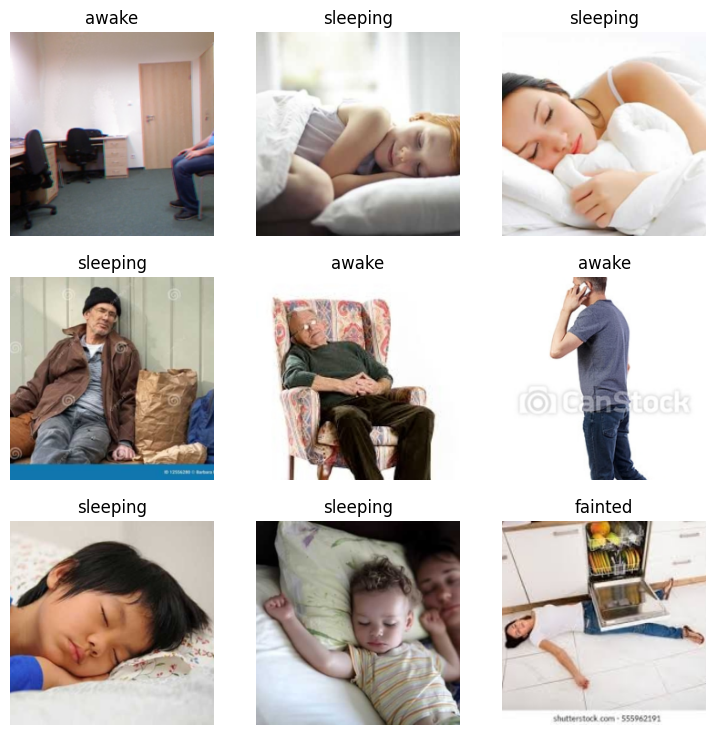

In [79]:
dls.show_batch(max_n=9)

# 4. Model Training

In [80]:
# 3. Create and train the model
epochs = 3 # More than 3 epochs caused overfitting
learn = vision_learner(dls, resnet34,
                       metrics=[error_rate, accuracy, Precision(average='macro'), Recall(average='macro')])

learn.fine_tune(epochs)


# # Step 1: Train just the "head" (the new classifier)
# # We keep the body frozen and use the high learning rate (2e-3)
# # that we know works for your dataset.
# learn.freeze()
# learn.fit_one_cycle(1, 2e-3)
#
# # Step 2: Train the whole model ("fine tuning")
# # We unfreeze the body and apply the slice:
# # - Low LR (1e-5) for the early layers (eye/shapes)
# # - High LR (2e-3) for the final layers (decision making)
# learn.unfreeze()
# learn.fit_one_cycle(10, slice(1e-5, 2e-3))


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,1.460890,0.594470,0.212766,0.787234,0.774769,0.816785,00:02


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.483595,0.318146,0.127660,0.872340,0.849723,0.895408,00:03
1,0.357451,0.127742,0.053191,0.946809,0.925203,0.955834,00:03
2,0.268809,0.100101,0.053191,0.946809,0.931495,0.955834,00:03


# 5. Evaluation

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

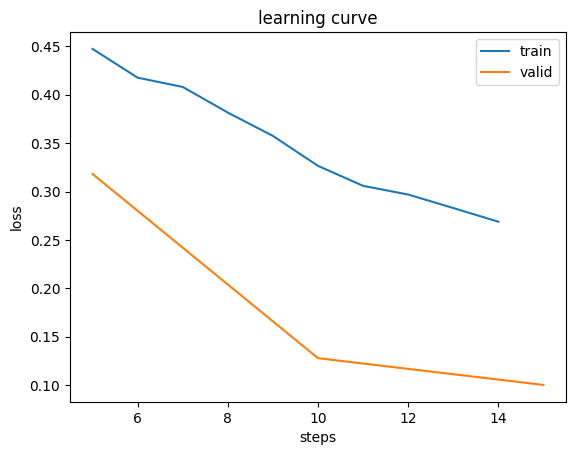

In [82]:
learn.recorder.plot_loss()

Plotting these metrics: ['error_rate', 'accuracy', 'precision_score', 'recall_score', 'time']


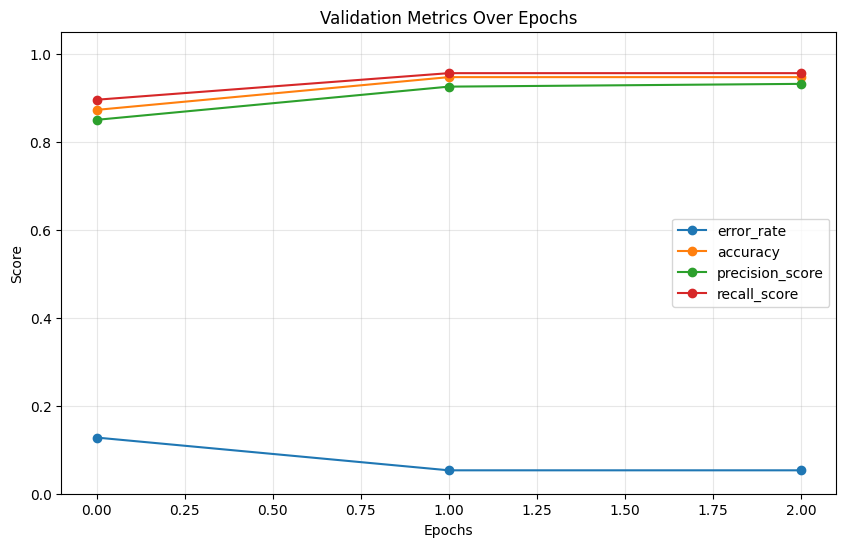

In [83]:
# 1. Grab the names of the metrics
metric_names = learn.recorder.metric_names[3:]
print(f"Plotting these metrics: {metric_names}")

# 2. Grab the actual numbers
values = list(zip(*learn.recorder.values))

# 3. Create the Plot
plt.figure(figsize=(10, 6))

for i, name in enumerate(metric_names):
    # We start fetching values from index 2 because indices 0 & 1 are losses
    if i + 2 < len(values):
        plt.plot(values[i+2], label=name, marker='o')

plt.title('Validation Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05) # Force y-axis to show 0% to 100%
plt.show()

In [19]:
# Evaluate each image with the model (only for visualization)
# for image in Path("data/test").ls():
#     pred_class, pred_idx, probs = learn.predict(image)
#     print(f"Image: {image.name}, Predicted: {pred_class}, Probability: {probs[pred_idx]:.4f}, Real Class: {image.parent.name}")
#     break

In [63]:
test_path = Path('data/test')
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files, with_labels=True)
results = learn.validate(dl=test_dl)

print(f"Validation Loss: {results[0]:.4f}")
print(f"Error Rate:      {results[1]:.2%}")
print(f"Accuracy:        {results[2]:.2%}")
print(f"Precision:       {results[3]:.2%}")
print(f"Recall:          {results[4]:.2%}")


Validation Loss: 0.2062
Error Rate:      6.67%
Accuracy:        93.33%
Precision:       93.56%
Recall:          93.33%


### 5.1 Confusion Matrix & top losses

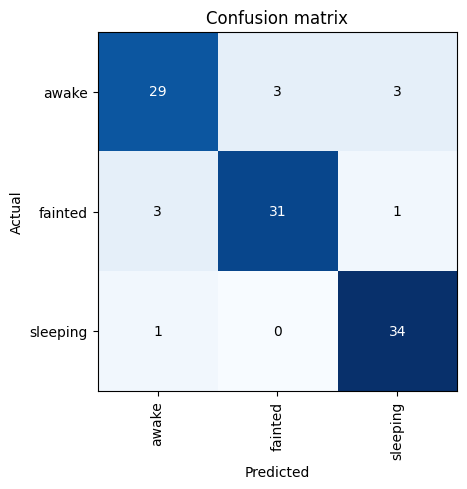

In [73]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()

### 5.2 Examples of predictions
* Incorrect Predictions:

/Users/asafshuster/PycharmProjects/fainting_image_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


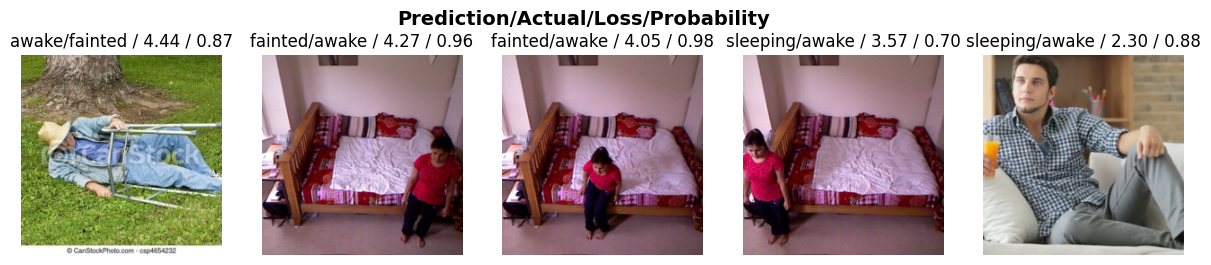

In [72]:
interp.plot_top_losses(5, nrows=1)

* Correct Predictions:

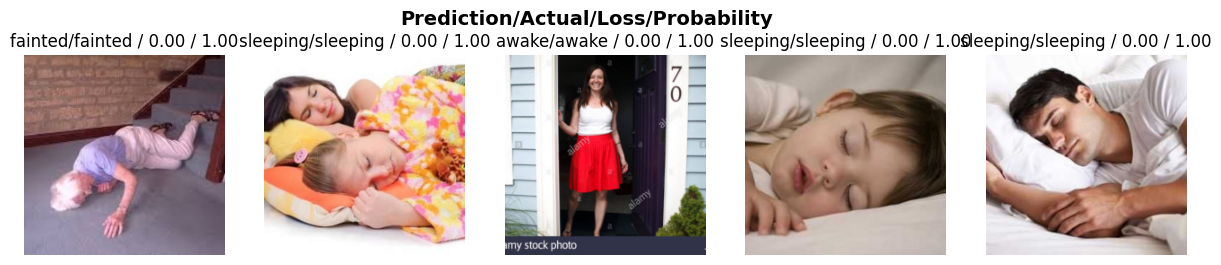

In [74]:
# largest=False asks for the SMALLEST loss (Best predictions)
interp.plot_top_losses(5, nrows=1, largest=False)

### 5.3 Discussion of Weaknesses & Conclusion
*Based on the metrics and visualizations above, we observe the following:*

**Strengths:**
* **High Precision on 'Sleeping' Class:** The model is exceptionally good at identifying sleeping subjects (34/35 correct in the test set), showing it has learned robust features for this state.
* **Balanced Performance:** With an overall test accuracy of ~90-93% and nearly identical Precision/Recall scores, the model is not biased toward any single class.
* **Efficient Training:** The model achieved peak performance using standard transfer learning (`fine_tune`) without requiring complex custom learning rate schedules, indicating the ResNet34 architecture fits this problem well.

**Weaknesses:**
* **'Awake' vs. 'Fainted' Ambiguity:** The primary source of error is distinguishing between 'Awake' and 'Fainted' (e.g., misclassifying 3 'Awake' subjects as 'Fainted'). This is the weakest point of the classifier.
* **Posture Confusion:** The model likely relies heavily on "horizontal posture" to predict Fainting. Consequently, "Awake" subjects who are lying down (e.g., on a sofa) are prone to being misclassified as Fainted.

**Future Improvements:**
* **Targeted Data Collection:** Collect more training images of "Awake" subjects in horizontal or relaxed positions (lying down but eyes open) to teach the model that posture alone does not define fainting.
* **Label Verification:** Review the specific "Awake" images with high loss to ensure they are not mislabeled or ambiguous.
* **Test Time Augmentation (TTA):** Implement TTA during inference to average predictions across multiple crops/flips, which could resolve the remaining ~7 marginal errors in the test set.